# Deployment Example and Analysis Code

This notebook demonstrates how the ML models we created can be deployed for stability and causality analysis of the EoS's.

First, we will import a model and its respective scaler, which have been saved as .pkl files.

In [9]:
import os
import pickle

def pickle_load(fname):

    file = open(fname,'rb')
    data = pickle.load(file)
    file.close()

    return data

#This contains all the files associated with a particular model
model_directory = 'Files_12_03_param_only_RfModel_MarginSamplingSelection/'

scaler = pickle_load(model_directory + 'scaler.pkl')
model = pickle_load(model_directory + 'model.pkl')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.24.2. Th

## Time-scale benchmarking
Now we want to do a timing analysis by benchmarking how long it takes to scale and classify 2k, 5k, 7k, 10k, 20k, and 30k samples. 

We picked a model that takes in EoS input parameters. Let's generate a grid that contains the space on which the model was trained (this information is in '~/config/parameter_space.json'). We can change the step-size by changing the corresponding default parameters. 

In [10]:
import json
import numpy as np
import random
import pandas as pd
import itertools

with open("config/parameter_space.json") as json_data_file:
    par = json.load(json_data_file)
    low_muB = par['low_muB']
    high_muB = par['high_muB']
    muB_inc = par['muB_inc']
    low_w = par['low_w']
    high_w = par['high_w']
    low_rho = par['low_rho']
    high_rho = par['high_rho']
    w_rho_inc = par['w_rho_inc']
    low_angle_diff = par['low_angle_diff']
    high_angle_diff = par['high_angle_diff']
    angle_diff_inc = par['angle_diff_inc']
    
    print(par)


{'low_muB': 220.0, 'high_muB': 420.0, 'low_w': 0.1, 'high_w': 10.0, 'low_rho': 0.1, 'high_rho': 10.0, 'low_angle_diff': -179.0, 'high_angle_diff': 179.0, 'muB_inc': 20, 'w_rho_inc': 0.5, 'angle_diff_inc': 5}


In [11]:
#By looking at the default values, we see that angle_diff_inc is set to 5 degrees. Let's change that to 3.
#We'll also change the muB_inc parameter to 25 MeV
angle_diff_inc = 3
muB_inc = 25

In [12]:
#Now we'll create a list with all possible values and combinations. 

muB_list = np.arange(low_muB, high_muB, muB_inc).tolist()
w_list = np.arange(low_w, high_w, w_rho_inc).tolist()
rho_list = np.arange(low_rho, high_rho, w_rho_inc).tolist()
angle_diff_list = np.arange(low_angle_diff, high_angle_diff, angle_diff_inc).tolist()

ranges = [muB_list, angle_diff_list, w_list, rho_list]
all_possible_combinations = list(itertools.product(*ranges))



#Create a Pandas Data Frame with all the possible parameters and their combination in a list
EOS =pd.DataFrame(data=all_possible_combinations, columns=['muB','angle_diff','w','rho'])


#combine all values into a list
EOS['combined']= EOS.values.tolist()


Let's check that everything looks ready to be preprocessed. 

In [13]:
EOS.head()

,muB,angle_diff,w,rho,combined
0,220.0,-179.0,0.1,0.1,"[220.0, -179.0, 0.1, 0.1]"
1,220.0,-179.0,0.1,0.6,"[220.0, -179.0, 0.1, 0.6]"
2,220.0,-179.0,0.1,1.1,"[220.0, -179.0, 0.1, 1.1]"
3,220.0,-179.0,0.1,1.6,"[220.0, -179.0, 0.1, 1.6]"
4,220.0,-179.0,0.1,2.1,"[220.0, -179.0, 0.1, 2.1]"


Our input now has the same format as our training data, so we're ready to take some samples. We will track how much time (in seconds per sample) it takes to scale and classify our input in each of the cases.

Assuming that we did not have ML-assited classification, each EOS requires a full generation + classification code. Running on a single CPU on the Illinois cluster, this takes about 30-50 seconds to complete. Let's take the average time to complete the analysis to be 40 seconds. This scales linearly with the number of EOS as time = 40*n_samples. This very quickly gets out of hand, wheareas with the ML classifer, after the initial computational investment to train the model, we can classify thousands of EOS in possibly miliseconds. So what is the gained speed factor? We'll look at both the ML-classification time per sample, and the speed gain factor compared to conventional classification. 

In [14]:
#Create lists of EoS's to label with the desired number of samples
import time 

n_samples = [2000,5000,7000, 10000,15000,20000,30000]

ML_times = []
speed_gain_factor = []

#Repeat experiment 50x
for iteration in range(0,50):
    time_as_a_func_of_n = [] #Reset every time the experiment is run
    time_by_itself = []
    for num_samples in n_samples:
        
        samples = random.sample(list(EOS['combined']), num_samples) #sample n combinations of parameters

        #initiate timer
        start = time.time()
        #transform input
        samples_scaled = scaler.transform(samples)
        #make predictions
        labels = model.predict(samples_scaled)
        #end timer and record total time
        end = time.time()
        time_as_a_func_of_n.append((end - start)/len(samples_scaled))
        time_by_itself.append((end - start)/len(samples_scaled))
    speed_gain_factor_of_interation = [40/j for j in time_by_itself]
        
    ML_times.append(time_as_a_func_of_n)
    speed_gain_factor.append(speed_gain_factor_of_interation)
    

In [15]:
#Let's store our results in data frames
ML_times_df = pd.DataFrame(ML_times, columns = ['2k','5k','7k','10k','15k','20k','30k']);

speed_gain_df =  pd.DataFrame(speed_gain_factor, columns = ['2k','5k','7k','10k','15k','20k','30k']);

#Then let's take the mean, max, and min for each value of n_samples in both cases 

In [16]:
#Perform jackknife sampling to determine mean estimate and 95% confidence interval

from astropy.stats import jackknife_stats

test_statistic = np.mean

ML_mean = []
ML_lower_error = []
ML_upper_error = []

speed_gain_mean = []
speed_gain_lower_error = []
speed_gain_upper_error =[]


for column in ['2k','5k','7k','10k','15k','20k','30k']:
    estimate, bias, stderr, conf_interval = jackknife_stats(ML_times_df[column].values, test_statistic, 0.682)
    
    ML_mean.append(estimate)
    ML_lower_error.append(conf_interval[0])
    ML_upper_error.append(conf_interval[1])
    
    estimate, bias, stderr, conf_interval = jackknife_stats(speed_gain_df[column].values, test_statistic, 0.682)
    
    speed_gain_mean.append(estimate)
    speed_gain_lower_error.append(conf_interval[0])
    speed_gain_upper_error.append(conf_interval[1])


    
ML_times_error= [ML_lower_error, ML_upper_error]
speed_gain_error= [speed_gain_lower_error, speed_gain_upper_error]

Let's plot our results... 

NameError: name 'n_samples' is not defined

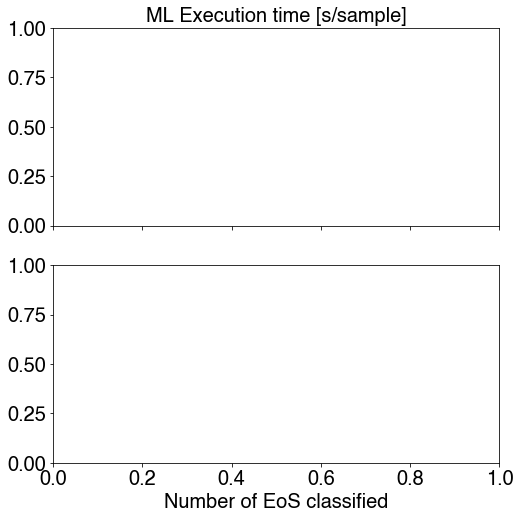

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl 

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.family'] = 'helvetica'
plt.rcParams['lines.markersize'] = 12

# #define error bars
# ML_lower_error = ML_times_df.loc['min'].values
# ML_upper_error = ML_times_df.loc['max'].values
# ML_times_error= [ML_lower_error, ML_upper_error]

# #define error bars
# speed_gain_lower_error = speed_gain_df.loc['min'].values
# speed_gain_upper_error = speed_gain_df.loc['max'].values
# speed_gain_error= [speed_gain_lower_error, speed_gain_upper_error]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax2.set_xlabel('Number of EoS classified')
ax1.set_title('ML Execution time [s/sample]', fontdict = {'fontsize': 20})

ax1.errorbar(n_samples, ML_mean, yerr=ML_times_error, fmt='-o',color='blue',
            capsize = 5)
ax1.tick_params(axis='y')


ax2.set_title('Speed gain factor ($t_{conventional}/t_{ML}$)',fontdict = {'fontsize': 20}) 
ax2.errorbar(n_samples, speed_gain_mean, yerr=speed_gain_error, fmt='-o',color='red',
            capsize = 5)
ax2.tick_params(axis='y')

ax1.set_yscale('log')
ax2.set_yscale('log')
plt.savefig('Plots/execution_and_speed_gain', bbox_inches='tight')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



### The data in this range suggests we gain 6 orders of magnitude in speed. 

----------------------------------------------------------------------------------------------------------------

# Studying the Parameter Space of the BEST EoS 

Let's reset our paramater space ranges and increments back to the default values. 

In [15]:
with open("config/parameter_space.json") as json_data_file:
    par = json.load(json_data_file)
    low_muB = par['low_muB']
    high_muB = par['high_muB']
    muB_inc = par['muB_inc']
    low_w = par['low_w']
    high_w = par['high_w']
    low_rho = par['low_rho']
    high_rho = par['high_rho']
    w_rho_inc = par['w_rho_inc']
    low_angle_diff = par['low_angle_diff']
    high_angle_diff = par['high_angle_diff']
    angle_diff_inc = par['angle_diff_inc']
    
    print(par)

{'low_muB': 220.0, 'high_muB': 420.0, 'low_w': 0.1, 'high_w': 10.0, 'low_rho': 0.1, 'high_rho': 10.0, 'low_angle_diff': -179.0, 'high_angle_diff': 179.0, 'muB_inc': 20, 'w_rho_inc': 0.5, 'angle_diff_inc': 5}


In [16]:
# Make plot: fixed alpha, fixed muB – show that rho is
# more important than w
# fix rho and muB, show smallest w as a function of alpha

Let's say we want to fix $\alpha_{\mathrm{diff}}$ = 10, 30, 90, 120 degrees and $\mu_{BC}$ = 400 MeV and investigate the effects of changing $\rho$ and $w$ on the stability/causality of the BEST EoS. 

In [17]:
#Modify input parameters
muB = [400]
angle_diff = [10,30,90,120]

#Now we'll create a list with all possible values and combinations. 

w_list = np.arange(low_w, high_w, w_rho_inc).tolist()
rho_list = np.arange(low_rho, high_rho, w_rho_inc).tolist()

ranges = [muB, angle_diff, w_list, rho_list]
all_possible_combinations = list(itertools.product(*ranges))



#Create a Pandas Data Frame with all the possible parameters and their combination in a list
EOS =pd.DataFrame(data=all_possible_combinations, columns=['muB','angle_diff','w','rho'])


#combine all values into a list
EOS['combined']= EOS.values.tolist()

In [18]:
EOS.head()

,muB,angle_diff,w,rho,combined
0,400,10,0.1,0.1,"[400.0, 10.0, 0.1, 0.1]"
1,400,10,0.1,0.6,"[400.0, 10.0, 0.1, 0.6]"
2,400,10,0.1,1.1,"[400.0, 10.0, 0.1, 1.1]"
3,400,10,0.1,1.6,"[400.0, 10.0, 0.1, 1.6]"
4,400,10,0.1,2.1,"[400.0, 10.0, 0.1, 2.1]"


In [19]:
#Transform input variables and make predictions (add as a column to the DataFrame)
EOS_scaled = scaler.transform(list(EOS['combined']))
#make predictions
EOS['labels'] = model.predict(EOS_scaled)

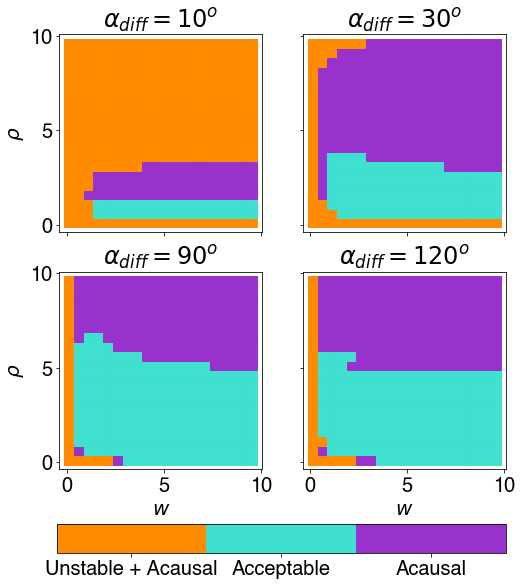

In [21]:
#Plot
from matplotlib.colors import ListedColormap

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:"darkorange",
          1:"turquoise",
          2:"darkorchid"}

# We create a colormap from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
col_labels = np.array(["Unstable + Acausal","Acceptable","Acausal"])
len_lab = len(col_labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: col_labels[norm(x)])


fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(EOS[EOS['angle_diff'] == 10]['w'].values, EOS[EOS['angle_diff'] == 10]['rho'].values,
                 marker = 's', s= 76, c = EOS[EOS['angle_diff'] == 10]['labels'].values,cmap=cm, norm=norm)
axs[0, 0].set_title(r"$\alpha_{diff} = 10^o$")


axs[0, 1].scatter(EOS[EOS['angle_diff'] == 30]['w'].values, EOS[EOS['angle_diff'] == 30]['rho'].values, 
              marker = 's', s= 76, c = EOS[EOS['angle_diff'] == 30]['labels'].values,cmap=cm, norm=norm)
axs[0, 1].set_title(r"$\alpha_{diff} = 30^o$")


axs[1, 0].scatter(EOS[EOS['angle_diff'] == 90]['w'].values, EOS[EOS['angle_diff'] == 90]['rho'].values,
                 marker = 's', s=76, c = EOS[EOS['angle_diff'] == 90]['labels'].values,cmap=cm, norm=norm)
axs[1, 0].set_title(r"$\alpha_{diff} = 90^o$")

a = axs[1, 1].scatter(EOS[EOS['angle_diff'] == 120]['w'].values, EOS[EOS['angle_diff'] == 120]['rho'].values, 
                 marker = 's', s= 76, c = EOS[EOS['angle_diff'] == 120]['labels'].values,cmap=cm, norm=norm)
axs[1, 1].set_title(r"$\alpha_{diff} = 120^o$")

for ax in axs.flat:
    ax.set(xlabel=r'$w$', ylabel=r'$\rho$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#     [left, bottom, width, height] 
cb_ax = fig.add_axes([.12,-0.02,.78,.05])
cb = fig.colorbar(a, ticks=[0., 1, 2], format=fmt,cax=cb_ax,orientation="horizontal")


fig.savefig('Plots/vary_w_and_rho',bbox_inches='tight')

Let's say we want to fix $\mu_{BC}$ = 250, 300, 350, 400 MeV and $\rho$ = 2, and investigate the smallest $w$ for which the you can produce a stable EoS as a function of $\alpha_\textrm{diff}$. In other words, for a particular location of the critical point, what is the largest critical region I can produce for a given angle when $\rho$ = 2?

In [18]:
#Once again, we reset our parameters

with open("config/parameter_space.json") as json_data_file:
    par = json.load(json_data_file)
    low_muB = par['low_muB']
    high_muB = par['high_muB']
    muB_inc = par['muB_inc']
    low_w = par['low_w']
    high_w = par['high_w']
    low_rho = par['low_rho']
    high_rho = par['high_rho']
    w_rho_inc = par['w_rho_inc']
    low_angle_diff = par['low_angle_diff']
    high_angle_diff = par['high_angle_diff']
    angle_diff_inc = par['angle_diff_inc']
    

#Modify input parameters
muB = [250,300,350,400]
rho = [2]
#We need a finer sampling in w
w_rho_inc = 0.1

#Now we'll create a list with all possible values and combinations. 

w_list = np.arange(low_w, high_w, w_rho_inc).tolist()
angle_diff_list = np.arange(low_angle_diff, high_angle_diff, angle_diff_inc).tolist()

ranges = [muB, angle_diff_list, w_list, rho]
all_possible_combinations = list(itertools.product(*ranges))



#Create a Pandas Data Frame with all the possible parameters and their combination in a list
EOS =pd.DataFrame(data=all_possible_combinations, columns=['muB','angle_diff','w','rho'])


#combine all values into a list
EOS['combined']= EOS.values.tolist()

In [19]:
#Transform input variables and make predictions (add as a column to the DataFrame)
EOS_scaled = scaler.transform(list(EOS['combined']))
#make predictions
EOS['labels'] = model.predict(EOS_scaled)

EOS.head()

,muB,angle_diff,w,rho,combined,labels
0,250,-179.0,0.1,2,"[250.0, -179.0, 0.1, 2.0]",0
1,250,-179.0,0.2,2,"[250.0, -179.0, 0.2, 2.0]",0
2,250,-179.0,0.3,2,"[250.0, -179.0, 0.30000000000000004, 2.0]",0
3,250,-179.0,0.4,2,"[250.0, -179.0, 0.4, 2.0]",0
4,250,-179.0,0.5,2,"[250.0, -179.0, 0.5, 2.0]",0


In [20]:
#For each value of muBC, we want to select the smallest stable w for each alpha_diff

#Select muB value 
all_pairs = []
for muBval in muB:
    list_vals = EOS[EOS['muB'] == muBval]

    #Select stable choices only
    list_vals_stable = list_vals[list_vals['labels'] == 1]

#For each alpha, get smallest w that is stable
    
    pairs = []
    for el in angle_diff_list:
        new_df = list_vals_stable[list_vals_stable['angle_diff'] == el]
        if len(new_df) != 0:
            pairs.append([el,min(new_df['w'])])
    all_pairs.append(pairs)

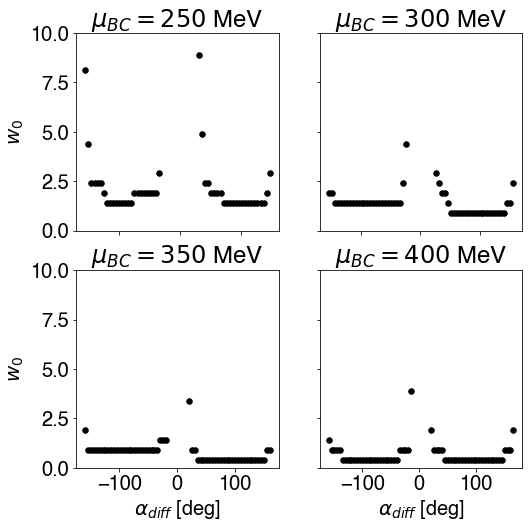

In [21]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(*zip(*all_pairs[0]),marker = 'o', s= 30, color='black')
axs[0, 0].set_title(r"$\mu_{BC} = 250$ MeV")
axs[0, 0].set_ylim([0, 10])


axs[0, 1].scatter(*zip(*all_pairs[1]),
                 marker = 'o', s= 30, color='black')
axs[0, 1].set_title(r"$\mu_{BC} = 300$ MeV")
axs[0, 1].set_ylim([0, 10])

axs[1, 0].scatter(*zip(*all_pairs[2]),
                 marker = 'o', s= 30, color='black')
axs[1, 0].set_title(r"$\mu_{BC} = 350$ MeV")
axs[1, 0].set_ylim([0, 10])

axs[1, 1].scatter(*zip(*all_pairs[3]),
                 marker = 'o', s= 30, color='black')
axs[1, 1].set_title(r"$\mu_{BC} = 400$ MeV")
axs[1, 1].set_ylim([0, 10])

for ax in axs.flat:
    ax.set(xlabel=r'$\alpha_{diff}$ [deg]', ylabel=r'$w_0$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

from matplotlib.pyplot import savefig

savefig('Plots/vary_alpha_and_w')

### It looks like two things are happening,
1) The further away from the T-axis we place the critical point, the bigger than range in $\alpha_{\textrm{diff}}$ for which you can construct a larger critical region (small w)

2) The further we get from orthogonality, the harder it is to get a stable EOS with a non-vanishing critical region (for w > 5 the critical region will be really small in most cases). Note that really small angles (|$\alpha_{\textrm{diff}}$| < 10) have no stable configurations for these choices of $\mu_{BC}$ and $\rho$.

### Note
Great Stackoverflow post on plotting with colorbar legend
https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar


## What points were queried?
The points that were queried by the active learning algorithm can tell us a lot about the parameter space of the model (i.e. stability region boundaries). Information about the point queried during training is stored in

~/EOS_ALF/Files_12_03_param_only_RfModel_MarginSamplingSelection/queried.dat

This file contains the indices of the points selected with respect to all the points generated.

In [26]:

import csv
#Import queried values as list
with open(model_directory + 'queried.dat', newline='') as f:
    reader = csv.reader(f)
    your_list = list(reader)

#Flatten list
flat_list = [item for sublist in your_list for item in sublist]
#Transform elements to ints
flat_list = list(map(int,flat_list))


In [65]:
#Import all files generated in training 
data = pd.read_csv('PC1PC2_all_thermo.dat', sep=" ", header=None)

column_names = ['CLASS','Tc', 'muBC','angle1','angle2','w','rho']
vector_names = [];

for i in range(0,1541):
    vector_names.append('v_' +  str(i+1))
    column_names.append('v_' +  str(i+1))

data.columns = column_names;
    
#Last column will be NaN so it should be dropped
data.drop(['v_1541'], axis=1, inplace = True);

vector_names.remove('v_1541');

#Check if there are any other NaN 
for i in range(0,1540):
    string = 'v_' +  str(i+1)
    check_for_nan = data[string].isnull().values.any()
    if check_for_nan == True:
        print('Check for NaN on ' + string)     

#get the angle_diff parameter
data.insert(3,'angle_diff', data['angle2'] - data['angle1'])
data = data.drop(columns = ['angle1','angle2'])

In [66]:
#We're only interested in the parameters associated with the point (the file contains more training information)
training_points = data[['muBC','angle_diff','w','rho']]
del(data)

In [67]:
#Now we make a list containing only the training points that were queried

queried_points = training_points.iloc[flat_list]

In [68]:
queried_points.head()

,muBC,angle_diff,w,rho
657,420.0,-168,6.1,5.1
6894,380.0,-163,6.1,0.6
12749,340.0,-13,9.1,0.6
12805,340.0,-113,8.1,8.1
6814,380.0,-18,5.6,3.6


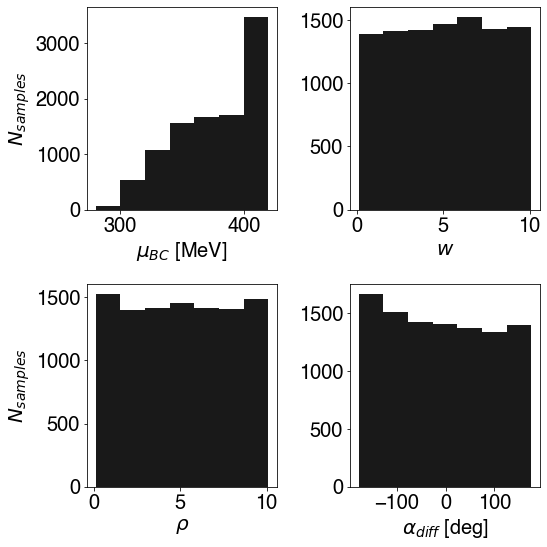

In [142]:
#Now we can make a histogram of the points that were queried in each of the independent variables
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.family'] = 'helvetica'
plt.rcParams['lines.markersize'] = 12

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(queried_points['muBC'], 7, color = 'black', alpha=0.9)
axs[0, 0].set_xlabel(r"$\mu_{BC}$ [MeV]")
axs[0, 0].set_ylabel(r"$N_{samples}$")


axs[0, 1].hist(queried_points['w'], 7, color = 'black', alpha=0.9)
axs[0, 1].set_xlabel(r"$w$")


axs[1, 0].hist(queried_points['rho'], 7, color = 'black', alpha=0.9)
axs[1,0].set_xlabel(r"$\rho$")
axs[1, 0].set_ylabel(r"$N_{samples}$")

axs[1, 1].hist(queried_points['angle_diff'], 7, color = 'black', alpha=0.9)
axs[1,1].set_xlabel(r"$\alpha_{diff}$ [deg]")

fig.tight_layout()

from matplotlib.pyplot import savefig

savefig('Plots/samples_histograms.png')

We see that the only parameter for which there is a clear bias in the points that are being sampled is $\mu_{BC}$. That is likely because the model does not struggle to classify critical points closer to the T-axis, which are largely unstable. However, in the larger $\mu_{B}$ regime, where tons of different critical points are allowed to exist, it needs more samples.